# <center>Unstructured Data Analysis</center>

MASNA 2019 Students <br>
Baranova Anastasia <br>
Gutman Irina

At first, plan was to parse litres.ru. In order to parse a book page, we need to somehow open it. We see two variants: first one is using selenium and imitating webbrowser and the other one is getting somewhere a list of book ids and opening pages using knowledge about url structure. We decided to try the second one. So the following code is aimed on getting book ids in order to parse a book page afterwards.

In [22]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
from collections import Counter
import numpy as np
%matplotlib inline  

In [20]:
book_ids = []
for i in range(1,100): 
    #the max range number here is a number of pages that should be scrolled down. 
    # On one page there are 100 books.
    r = requests.get('https://www.litres.ru/luchshie-knigi/pechatnye-knigi/page-'+str(i)+'/')
    html = r.text
    soup = BeautifulSoup(html, "html.parser")    
    for element in soup.findAll('a',class_='img-a'):
        book_id = element.get('data-art')
        book_ids.append(book_id)

In [19]:
pd.DataFrame(book_ids).to_csv('book_ids.csv') #saving book_ids to csv

Getting data on books from book's page

In [36]:
book_ids = pd.read_csv('book_ids.csv')

In [50]:
r = requests.get('https://www.litres.ru/38571833') #trying one book to check how it is going
html = r.text
soup = BeautifulSoup(html, "html.parser")
soup

And here we were banned by site. Oh. It appeared that there is a limit on requests after which the site wants to know that you are not a robot and shows CAPTCHA. We did not find a solution for this so we tried to find another way. One way could be using an API of Litres if there is one.

So we looked for API of litres in case they have it and... https://www.litres.ru/o-kompanii/partneram/instrumenty/ It was Jackpot. On the site litress provide an xml file with all data on books. 5 Gigabytes of data, actually. Maybe too much for downloading and working with at one time, so let's try iterating through XML.

In [1]:
import xml.etree.ElementTree as ET

In [80]:
# Here we tried to iterate through the xml. It took an hour and a half (then we stopped the process)
# and we got 100'000 rows of data after that time. We decided it is enough for our aims.
i=0
genre=[]
title=''
annotation=''
data = pd.DataFrame(columns=['genre', 'annotation', 'title'])
for event, elem in ET.iterparse("detailed_data_raw.xml", events=("start","end")):
    if len(data)>=100: #example
        break
    if elem.tag == "genre" and event == 'end':
        genre.append(elem.text)
        elem.clear()
    if elem.tag == "book-title" and event == 'end':
        title = elem.text
        elem.clear()
    if elem.tag == "p" and event == 'end':
        if elem.text is not None:
            annotation = annotation + elem.text
        elem.clear()
    if elem.tag == "art" and event == 'end':
        data = data.append({"genre":genre, "annotation": annotation, "title": title}, ignore_index=True)
        genre=[]
        title=''
        annotation=''
data.head()

KeyboardInterrupt: 

In [82]:
len(data) # we had 116611

116611

In [83]:
data.to_csv('raw_data.csv') #saving data to csv

In [4]:
data=pd.read_csv('raw_data.csv')

Manual Data clustering

The problem with data is that there are more then 150 genres and it appeared that there could be more then 1 genre for a book. So that classificatopn would be difficult and ineffective. We decided to make two classes from data.

In [5]:
data=data[['genre','annotation','title']].dropna() #getting rid from null values. 
#A small part of data was parsed with null values in annotation. This is due to null values in xml file.
data.head()

,genre,annotation,title
0,"['sf_social', 'sf_history']","Мир на пороховой бочке, и несколько раз за век...",Армагед-дом
1,['magician_book'],В довольно-таки мрачном фэнтезийном мире зарож...,Скрут
2,['magician_book'],Ты можешь летать на птице или нырять на оседла...,Варан
3,"['sf_space', 'narrative']","История одного батальона, отслеженная писателе...",Десант на Счастье
4,"['sf_space', 'narrative']",Долгие годы последствия Галактической войны бу...,Повторная колонизация


In [6]:
# sampling with filter in order to manually check some genres.
number_of_samples = 10
df1 = data[data.genre == '[\'industries\']'].sample(number_of_samples)
df1

,genre,annotation,title
93264,['industries'],Книга представляет собой практическое руководс...,Управление предприятием в условиях дефицита об...
65875,['industries'],В шестнадцатом ежегодном аналитическом докладе...,Население России 2008. Шестнадцатый ежегодный ...
79951,['industries'],"Владимир Познер, Алексей Венедиктов, Николай С...",Акулы интервью. 11 мастер-классов
9639,['industries'],Строительство представляет собой одну из важне...,Управление градостроительным комплексом в Росс...
65876,['industries'],"В семнадцатом ежегодном аналитическом докладе,...",Население России 2009. Семнадцатый ежегодный д...
107201,['industries'],Книга посвящена созданию в компании общей стра...,Продажи. Выиграй в конкурентной борьбе
94133,['industries'],Учебное пособие подготовлено в соответствии с ...,Слесарное дело
59052,['industries'],"В пособии изложено содержание, порядок и сроки...",Противопожарный инструктаж: Пособие по всем ви...
96733,['industries'],Приведены основные направления модернизации фе...,Технологическое оборудование для производства ...
101711,['industries'],В доступной форме и на высоком профессионально...,Страхование. Ответы на экзаменационные билеты


In [26]:
#creating a list of genres in order to check how many of them there are and check the distribution
list_of_genres=[]
batch_size = 10000 # We had a limit on speed for our notebook so this is batching for limit speed artificially
time_to_sleep = 15 #after each batch - wait 'time_to_sleep' seconds
i=0 
for genresJson in data['genre']:
    genresJson = genresJson.replace('\'', '"')
    genres = json.loads(genresJson)
    list_of_genres+=genres
    i += 1
    if i % batch_size == 0:
        print (i," items done")
        time.sleep(time_to_sleep)
print(list_of_genres)

10000  items done
20000  items done
30000  items done
40000  items done
50000  items done
60000  items done
70000  items done
80000  items done
90000  items done
100000  items done


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
my_counter = Counter(list_of_genres)
print(len(my_counter))
[(l,k) for k,l in sorted([(j,i) for i,j in my_counter.items()], reverse=True)] # sorted by key counter

[('short_story', 1700),
 ('sf', 1223),
 ('prose_rus_classic', 806),
 ('russian_contemporary', 760),
 ('detective', 654),
 ('det_action', 428),
 ('literature_19', 410),
 ('narrative', 400),
 ('fantasy_fight', 391),
 ('literature_20', 387),
 ('det_irony', 339),
 ('sf_social', 338),
 ('sf_action', 334),
 ('sf_humor', 297),
 ('prose_history', 294),
 ('love_contemporary', 275),
 ('ref_ref', 245),
 ('nonf_biography', 206),
 ('foreign_prose', 203),
 ('love_erotica', 199),
 ('sf_horror', 195),
 ('det_crime', 188),
 ('magician_book', 187),
 ('sf_space', 178),
 ('love_history', 174),
 ('det_police', 173),
 ('sci_history', 158),
 ('prose_classic', 156),
 ('child_det', 147),
 ('sf_heroic', 141),
 ('child_sf', 135),
 ('sf_history', 130),
 ('child_prose', 130),
 ('love_detective', 124),
 ('sci_juris', 122),
 ('prose_su_classics', 120),
 ('home_health', 114),
 ('foreign_sf', 112),
 ('child_tale', 111),
 ('dramaturgy', 105),
 ('popadanec', 103),
 ('humor_fantasy', 97),
 ('historical_fantasy', 93),
 ('

In [223]:
# Getting to classes of books: connected with science and not connected.
book_class=[]
for row in data['genre']:
    this_genre = row.strip('][').split(', ') 
    if  any("nonf" in s for s in this_genre)\ #nonfiction bookd
        or any("economics" in s for s in this_genre)\ #economics since it is a big cluster and it is a science
        or any("sci" in s for s in this_genre): # science
        book_class.append('science')
        continue
    else:
        book_class.append('other')

([0, 1], <a list of 2 Text xticklabel objects>)

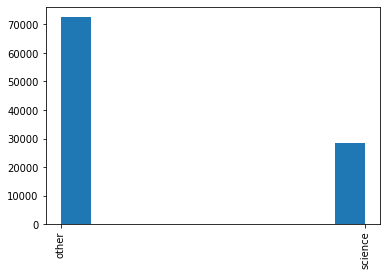

In [224]:
plt.hist(book_class,align='mid',rwidth =1)

In [225]:
data['book_class']=book_class

In [226]:
data.head()

,genre,annotation,title,book_class
0,"['sf_social', 'sf_history']","Мир на пороховой бочке, и несколько раз за век...",Армагед-дом,other
1,['magician_book'],В довольно-таки мрачном фэнтезийном мире зарож...,Скрут,other
2,['magician_book'],Ты можешь летать на птице или нырять на оседла...,Варан,other
3,"['sf_space', 'narrative']","История одного батальона, отслеженная писателе...",Десант на Счастье,other
4,"['sf_space', 'narrative']",Долгие годы последствия Галактической войны бу...,Повторная колонизация,other


In [227]:
data.to_csv('data_for_classification.csv') #saving data to csv with 2 classes